In [2]:
import os
import os.path as osp
from PIL import Image
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../../utils')
import paired_transforms_tv04 as p_tr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [4]:
import torch
torch.manual_seed(0)

from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split

In [5]:
path_train = '../../data/DRIVE/training/'
path_test = '../../data/DRIVE/test'

In [6]:
class DRIVE(Dataset):
    def __init__(self, path_to_data, mode='train', proportion=1, transforms=None, label_values=None):
        # initialize variables
        self.path_to_data = path_to_data
        self.transforms = transforms
        self.im_list = sorted(os.listdir(osp.join(path_to_data, 'images')))
        self.gt_list = sorted(os.listdir(osp.join(path_to_data, '1st_manual')))
        self.mask_list = sorted(os.listdir(osp.join(path_to_data, 'mask')))
        # proportion of images used; for test dataset, should be 1
        num_ims = len(self.im_list)
        if mode == 'train':
            self.im_list = self.im_list[:int(proportion*num_ims)]
            self.gt_list = self.gt_list[:int(proportion*num_ims)]
            self.mask_list = self.mask_list[:int(proportion*num_ims)]
        elif mode =='val':
            self.im_list = self.im_list[int(proportion*num_ims):] 
            self.gt_list = self.gt_list[int(proportion*num_ims):]
            self.mask_list = self.mask_list[int(proportion*num_ims):]
        self.label_values = label_values # for use in label_encoding
        
    def label_encoding(self, gdt):
        gdt_gray = np.array(gdt.convert('L'))
        classes = np.arange(len(self.label_values))
        for i in classes:
            gdt_gray[gdt_gray==self.label_values[i]]=classes[i]
        return Image.fromarray(gdt_gray)
    
    def crop_to_fov(self, img, target, mask):
        minr, minc, maxr, maxc = regionprops(np.array(mask))[0].bbox
        im_crop = Image.fromarray(np.array(img)[minr:maxr, minc:maxc])
        tg_crop = Image.fromarray(np.array(target)[minr:maxr, minc:maxc])
        mask_crop = Image.fromarray(np.array(mask)[minr:maxr, minc:maxc])
        return im_crop, tg_crop, mask_crop
    
    def __getitem__(self, index):
        # load image and labels
        img = Image.open(osp.join(self.path_to_data, 'images', self.im_list[index]))
        target = Image.open(osp.join(self.path_to_data, '1st_manual', self.gt_list[index]))
        mask = Image.open(osp.join(self.path_to_data, 'mask', self.mask_list[index]))
        img, target, mask = self.crop_to_fov(img, target, mask)
        
        target = self.label_encoding(target)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
        
    def __len__(self):
        return len(self.im_list)

In [7]:
train_proportion=0.8
train_dataset = DRIVE(path_train, mode='train', proportion=train_proportion, label_values = [0,255])
val_dataset = DRIVE(path_train, mode='val', proportion=train_proportion, label_values = [0,255])

In [8]:
len(train_dataset), len(val_dataset)

(16, 4)

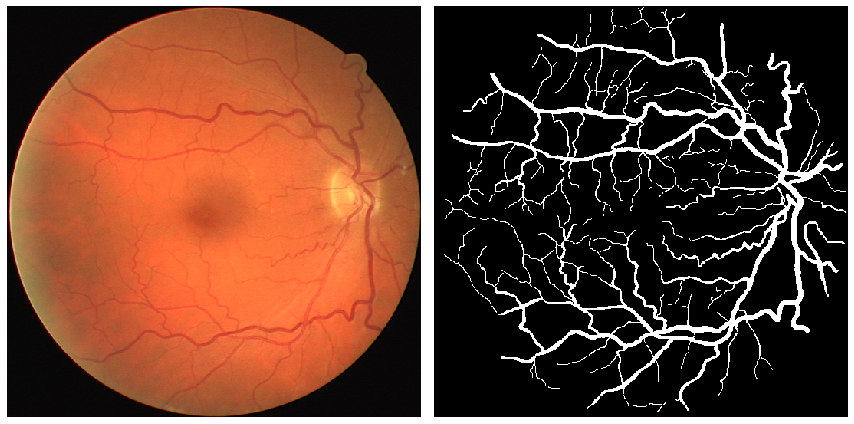

In [9]:
imshow_pair(*train_dataset[1])

In [10]:
# transforms
size = 512, 512
resize = p_tr.Resize(size)

rotate = p_tr.RandomRotation(degrees=45)
scale = p_tr.RandomAffine(degrees=0, scale=(0.95, 1.20))
transl = p_tr.RandomAffine(degrees=0, translate=(0.05, 0))
# either translate, rotate, or scale
scale_transl_rot = p_tr.RandomChoice([scale, transl, rotate])

h_flip = p_tr.RandomHorizontalFlip()
v_flip = p_tr.RandomVerticalFlip()

brightness, contrast, saturation, hue = 0.25, 0.25, 0.25, 0.01
jitter = p_tr.ColorJitter(brightness, contrast, saturation, hue)

Note: to understand why we use `p_tr` here you can have a look at [this link](https://github.com/agaldran/torchvision_paired_transforms).

In [11]:
# composed paired transforms
train_transforms = p_tr.Compose([resize, scale_transl_rot, h_flip, v_flip, jitter])

In [12]:
train_dataset.transforms = train_transforms

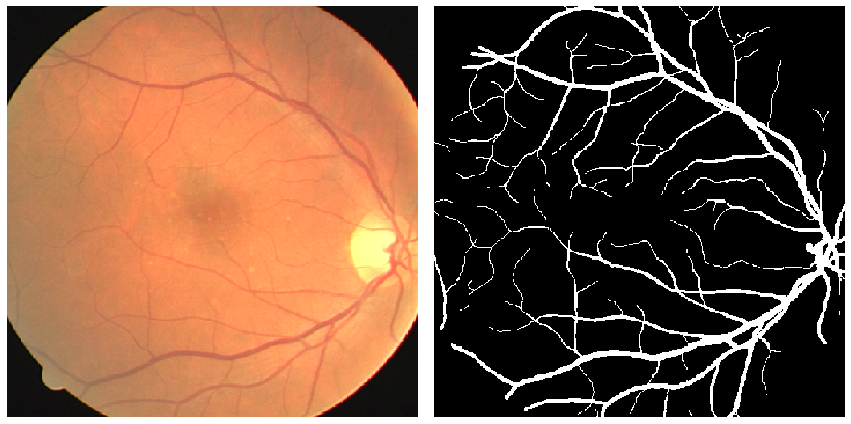

In [14]:
imshow_pair(*train_dataset[0])

In [15]:
tensorizer = p_tr.ToTensor()

train_transforms = p_tr.Compose([resize, scale_transl_rot, h_flip, v_flip, jitter, tensorizer])
train_dataset.transforms = train_transforms

val_transforms = p_tr.Compose([resize, tensorizer])
val_dataset.transforms = val_transforms

In [16]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, num_workers=8)

In [17]:
batch = next(iter(train_loader))

In [18]:
batch[0].shape, batch[1].shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))

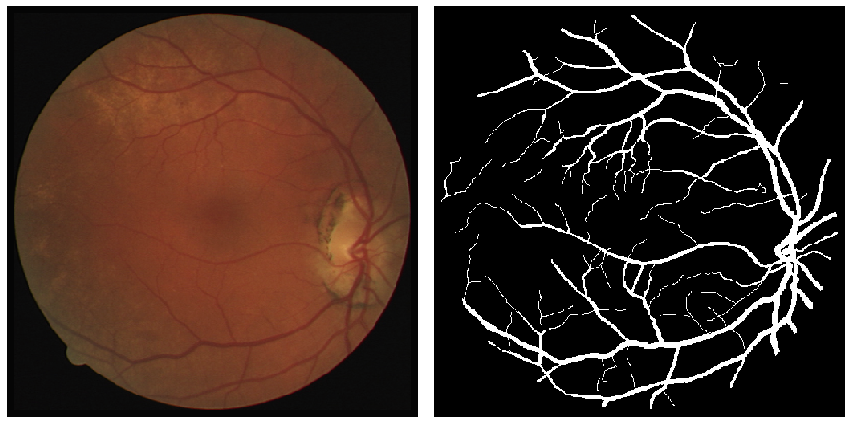

In [19]:
imshow_pair(*p_tr.ToPILImage()(batch[0][0], batch[1][0]))

In [20]:
batch = next(iter(val_loader))

In [21]:
batch[0].shape, batch[1].shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))